In [1]:
import numpy as np
import pandas as pd
import json
from utils import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, GRU, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn import preprocessing
from keras.utils import plot_model
import matplotlib.pyplot as plt

In [2]:
train_df = pd.DataFrame(columns=['id','postText','truthMedian','truthClass','truthMean'])
with open('data/train.json') as json_data:
    data = json.load(json_data)
    for instance in data:
        train_instance = {'id': instance['text_id'], 'postText': instance['post_text'], 'truthMedian': instance['truth_median'], 'truthClass': instance['click_bait'], 'truthMean': instance['truth_mean']}
        train_df = train_df.append(train_instance, ignore_index = True)
train_df.head()

,id,postText,truthMedian,truthClass,truthMean
0,849630396191055872,"Flying mattress strikes biker at 50 mph, ends ...",0.000000,0,0.200000
1,805003400136036352,The Grand Tour: Jeremy Clarkson is really taun...,0.000000,0,0.200000
2,811134324628226048,Was this murderous attack on a Russian diploma...,0.666667,1,0.533333
3,807681539580502016,"PartyNextDoor brings out Drake, G-Eazy and mor...",0.000000,0,0.266667
4,807465142032232450,A far-right Dutch lawmaker who wants to Make t...,0.000000,0,0.200000


In [3]:
test_df = pd.DataFrame(columns=['id','postText','truthMedian','truthClass','truthMean'])
with open('data/test.json') as json_data:
    data = json.load(json_data)
    for instance in data:
        test_instance = {'id': instance['text_id'], 'postText': instance['post_text'], 'truthMedian': instance['truth_median'], 'truthClass': instance['click_bait'], 'truthMean': instance['truth_mean']}
        test_df = test_df.append(test_instance, ignore_index = True)
test_df.head()

,id,postText,truthMedian,truthClass,truthMean
0,841383755944189952,"John Lewis blasts GOP rep's ""bigoted and racis...",0.000000,0,0.200000
1,852354010820620288,The NBA playoff bracket is now set,0.000000,0,0.200000
2,838728651545903104,Migrants smash up German asylum centre and sev...,0.000000,0,0.133333
3,805465449739718656,"America's most livable states, ranked",0.666667,1,0.666667
4,841713776382627840,WIP or RIP?,1.000000,1,0.933333


In [4]:
# Convert floating number in 'truthMedian' column to integer
train_df['truthMedian'] = train_df['truthMedian'].apply(medianToInteger)
# Remove all punctuations and clear the text
train_df['postText'] = train_df['postText'].apply(cleanText)
train_df.head()

,id,postText,truthMedian,truthClass,truthMean
0,849630396191055872,flying mattress strikes biker at 50 mph ends u...,0,0,0.200000
1,805003400136036352,the grand tour jeremy clarkson is really taunt...,0,0,0.200000
2,811134324628226048,was this murderous attack on a russian diploma...,2,1,0.533333
3,807681539580502016,partynextdoor brings out drake geazy and more ...,0,0,0.266667
4,807465142032232450,a farright dutch lawmaker who wants to make th...,0,0,0.200000


In [5]:
# Convert floating number in 'truthMedian' column to integer
test_df['truthMedian'] = test_df['truthMedian'].apply(medianToInteger)
# Remove all punctuations and clear the text
test_df['postText'] = test_df['postText'].apply(cleanText)
test_df.head()

,id,postText,truthMedian,truthClass,truthMean
0,841383755944189952,john lewis blasts gop reps bigoted and racist ...,0,0,0.200000
1,852354010820620288,the nba playoff bracket is now set,0,0,0.200000
2,838728651545903104,migrants smash up german asylum centre and sev...,0,0,0.133333
3,805465449739718656,americas most livable states ranked,2,1,0.666667
4,841713776382627840,wip or rip,3,1,0.933333


In [6]:
# length of titles with longest words
maxLen = max(maxLengthInPostText(train_df), maxLengthInPostText(test_df))
maxLen

25

In [7]:
X_train, Y_train = np.array(train_df["postText"].tolist()), np.array(train_df["truthMedian"].tolist())
X_test, Y_test = np.array(test_df["postText"].tolist()), np.array(test_df["truthClass"].tolist())
print(X_train[0:10])
print(Y_train[0:10])

['flying mattress strikes biker at 50 mph ends up cushioning his fall by'
 'the grand tour jeremy clarkson is really taunting the bbc now'
 'was this murderous attack on a russian diplomat revenge for turkeys dirty deal with putin'
 'partynextdoor brings out drake geazy and more at summers over concert in la'
 'a farright dutch lawmaker who wants to make the netherlands great again was convicted of inciting discrimination'
 'this prince bought plane tickets for his 80 falcons casual'
 'kristen bell explains to cbs news why her daughters dont watch frozen'
 'the internet reacts predictably to trumps mysterious sweden incident'
 'isis is on the offensive and may have just picked up a surfacetoair missile system'
 'were watching how the markets are responding to trumps']
[0 0 2 0 0 3 0 2 0 1]


In [8]:
# import the glove word embedding file
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B/glove.6B.100d.txt')

In [9]:
Indices = sentences_to_indices(X_train,word_to_index, maxLen)
print("X_Train_indices =\n", Indices.shape)

X_Train_indices =
 (15567, 25)


In [10]:
def ClickBait_BiLSTM(input_shape, word_to_vec_map, word_to_index):
    sentence_indices = Input(input_shape, dtype='int32')
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    # Propagate sentence_indices through your embedding layer
    embeddings = embedding_layer(sentence_indices)   
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    X = Bidirectional(LSTM(128, return_sequences=True))(embeddings)
    # dropout
    X = Dropout(0.5)(X)
    X = Bidirectional(LSTM(128, return_sequences=True))(X)
    # dropout
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = Bidirectional(LSTM(128, return_sequences=False))(X)
    # dropout
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with 2 units
    X = Dense(4)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)  
    # Create Model instance which converts sentence_indices into X.
    model = Model(sentence_indices, X) 
    return model

In [11]:
BiLSTM_model = ClickBait_BiLSTM((maxLen,), word_to_vec_map, word_to_index)
BiLSTM_model.summary()
#plot_model(BiLSTM_model)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 25, 100)           40000100  
_________________________________________________________________
bidirectional (Bidirectional (None, 25, 256)           234496    
_________________________________________________________________
dropout (Dropout)            (None, 25, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 25, 256)           394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 256)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               394240

In [12]:
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [13]:
opt = Adam(learning_rate=3e-4)
callback = EarlyStopping(monitor='val_get_f1', mode='max', patience=3)

In [14]:
BiLSTM_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy',get_f1])

In [15]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 4)
X_train_indices.shape

(15567, 25)

In [16]:
history = BiLSTM_model.fit(X_train_indices, Y_train_oh, epochs = 20, validation_split=0.2, callbacks=[callback], batch_size = 64, shuffle=True)

Epoch 1/20
195/195 [==============================] - 19s 76ms/step - loss: 1.1108 - accuracy: 0.5177 - get_f1: 0.4027 - val_loss: 0.9795 - val_accuracy: 0.5562 - val_get_f1: 0.5028
Epoch 2/20
195/195 [==============================] - 15s 77ms/step - loss: 0.9947 - accuracy: 0.5610 - get_f1: 0.4994 - val_loss: 0.9370 - val_accuracy: 0.5803 - val_get_f1: 0.5258
Epoch 3/20
195/195 [==============================] - 16s 80ms/step - loss: 0.9581 - accuracy: 0.5817 - get_f1: 0.5250 - val_loss: 0.9242 - val_accuracy: 0.5861 - val_get_f1: 0.5454
Epoch 4/20
195/195 [==============================] - 16s 80ms/step - loss: 0.9535 - accuracy: 0.5767 - get_f1: 0.5181 - val_loss: 0.9180 - val_accuracy: 0.5861 - val_get_f1: 0.5303
Epoch 5/20
195/195 [==============================] - 16s 80ms/step - loss: 0.9388 - accuracy: 0.5938 - get_f1: 0.5296 - val_loss: 0.9271 - val_accuracy: 0.5706 - val_get_f1: 0.5391
Epoch 6/20
195/195 [==============================] - 16s 81ms/step - loss: 0.9173 - accur

dict_keys(['loss', 'accuracy', 'get_f1', 'val_loss', 'val_accuracy', 'val_get_f1'])


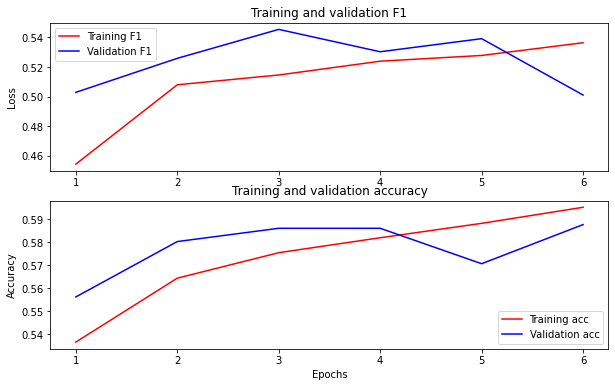

In [17]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['get_f1']
val_loss = history_dict['val_get_f1']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training F1')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation F1')
plt.title('Training and validation F1')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [18]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,roc_auc_score, mean_squared_error, classification_report
y_train_pred_oh = BiLSTM_model.predict(X_train_indices)
y_train_pred_binary = onehot_to_binary(y_train_pred_oh)
Y_train_binary = onehot_to_binary(Y_train_oh)

print("LSTM Training Accuracy")
print('Accuracy %s' % accuracy_score(Y_train_binary, y_train_pred_binary))
print('Precision %s' % precision_score(Y_train_binary, y_train_pred_binary))
print('Recall %s' % recall_score(Y_train_binary, y_train_pred_binary))
print('F1 score: %s' % f1_score(Y_train_binary, y_train_pred_binary))
#print('MSE %s' % mean_squared_error(Y_train_mean, y_train_pred_binary))

LSTM Training Accuracy
Accuracy 0.8412667822958824
Precision 0.6714573153204944
Recall 0.6375545851528385
F1 score: 0.6540669186616268


In [19]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
y_pred_onehot = BiLSTM_model.predict(X_test_indices)
y_pred_binary = onehot_to_binary(y_pred_onehot)

print("LSTM Testing Accuracy")
print('Accuracy %s' % accuracy_score(Y_test, y_pred_binary))
print('Precision %s' % precision_score(Y_test, y_pred_binary))
print('Recall %s' % recall_score(Y_test, y_pred_binary))
print('F1 score: %s' % f1_score(Y_test, y_pred_binary))
#print('MSE %s' % mean_squared_error(Y_test_mean, y_pred_binary))

LSTM Testing Accuracy
Accuracy 0.8211716341212744
Precision 0.675392670157068
Recall 0.6256062075654704
F1 score: 0.6495468277945619


In [20]:
print("LSTM Testing report")
print(classification_report(Y_test, y_pred_binary))

LSTM Testing report
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      2861
           1       0.68      0.63      0.65      1031

    accuracy                           0.82      3892
   macro avg       0.77      0.76      0.76      3892
weighted avg       0.82      0.82      0.82      3892



In [21]:
# Save our model
BiLSTM_model.save("BiLSTM_model.h5")

In [22]:
# Write output to test_df
def predict(headline):
    headline = cleanText(headline)
    headline_np = np.array([headline])
    indices = sentences_to_indices(headline_np, word_to_index, max_len = maxLen)
    y_pred_onehot = BiLSTM_model.predict(indices)
    return y_pred_onehot[0][3] + y_pred_onehot[0][2]

In [23]:
# test_df['predicted_prob_LSTM'] = test_df['postText'].apply(predict)
# test_df.head()

In [26]:
# Error Analysis
for i in range(100):
    if Y_test[i] - y_pred_binary[i] != 0:
        print(X_test[i])
        print("Actual Label",Y_test[i])
        print("Prediction Lable",y_pred_binary[i])
        print("Prediction",y_pred_onehot[i])
        print("-------------")

americas most livable states ranked
Actual Label 1
Prediction Lable 0
Prediction [0.3508477  0.32837105 0.18753807 0.13324323]
-------------
can a law stop distracted driving california hopes to find out
Actual Label 0
Prediction Lable 1
Prediction [0.08762857 0.37115538 0.37880751 0.16240858]
-------------
whats the no 1 ranking worth for the top golfers maybe nothing more than an ego boost
Actual Label 0
Prediction Lable 1
Prediction [0.15067658 0.24432018 0.33596367 0.26903963]
-------------
this transcript of donald trumps victory rally should terrify anyone with a reading age over 12
Actual Label 1
Prediction Lable 0
Prediction [0.5874814  0.3102917  0.08233869 0.01988821]
-------------
the one thing opec dreads is the return of shale and that may be happening via
Actual Label 0
Prediction Lable 1
Prediction [0.07793313 0.3258789  0.3879051  0.20828289]
-------------
kind of a john madden observation tbh
Actual Label 1
Prediction Lable 0
Prediction [0.15561606 0.3832327  0.3217061

In [27]:
headline = "Here are 10 things you may not know"
predict(headline)

0.88555664